# Imports

In [28]:
import os
from PIL import Image
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets,transforms,models
from torchvision.datasets import ImageFolder

In [2]:
#Checking the number of images in our dataset
path=('.')
files_training = glob(os.path.join(path, '*/*.png'))
num_images = len(files_training)
print('Number of images in Data folder:', num_images)

Number of images in Data folder: 27558


In [3]:
class_names = ['Parasitized','Uninfected']

In [4]:
#Finding the number of images per class
for folders in os.listdir('.'):
    if (folders=='Parasitized') or (folders=='Uninfected'):
        folder = len(os.listdir(os.path.join(path,folders)))
        print(f"There are {folder} {folders} images \n")

There are 13780 Parasitized images 

There are 13780 Uninfected images 



In [5]:
#Use GPU if available
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define our transforms

In [13]:
#Data Augmentation

data_transforms = {  
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], #Imagenet mean
                                                            [0.229, 0.224, 0.225])]), #Imagenet std,
    'valid': transforms.Compose([
        transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])}


# Create two Datasets

In [14]:
#Create indexes to split data into training and validation set.
np.random.seed(13)
shuffle = np.random.permutation(num_images)
shuffle

array([13261,  5946,  2398, ...,    74, 14512,   338])

In [15]:
split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number of valid images after split:',len(shuffle[:split_val]))
print('Number of train images after split:',len(shuffle[split_val:]))

Total number of images: 27558
Number of valid images after split: 5511
Number of train images after split: 22047


In [16]:
#Create datasets classes in order to separate our images into two sets: one training and one validation set.
class TrainDataset(Dataset):
    def __init__(self, files, shuffle, split_val,class_names, transform=None):
        self.class_names = class_names
        self.shuffle = shuffle
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[1]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y
    
class ValDataset(Dataset):
    def __init__(self, files, shuffle, split_val,class_names, transform=None):
        self.class_names = class_names
        self.shuffle = shuffle
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[1]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

In [17]:
#Datasets
train_dataset=TrainDataset(files=files_training, shuffle=shuffle,split_val=split_val,class_names=class_names,transform=data_transforms['train'])

valid_dataset=ValDataset(files=files_training, shuffle=shuffle,split_val=split_val,class_names=class_names,transform=data_transforms['valid'])

# Create two Dataloaders

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,num_workers=4)

In [22]:
#Transforms our dataset and dataloaders into something more convenient to deal with

image_datasets= {'train': train_dataset,
              'valid': valid_dataset}

dataloaders = {'train': train_loader,
              'valid': valid_loader}

dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset)}

# Exploratory Data Analysis

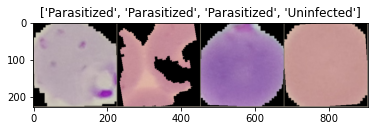

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train the model

In [49]:
total_train_loss=[]
total_valid_loss=[]
total_train_acc=[]
total_valid_acc=[]

def train(n_epochs, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for maximum validation accuracy
    valid_acc_min=0
    # initialize variables to track the evolution of the loss and the accuracy.
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to track training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        #train the model: training phase
        model.train()
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            outputs = model(images)
            
            # calculate loss
            loss = criterion(outputs, labels)
            
            # back prop
            loss.backward()
            
            # updates the weights
            optimizer.step()
            
            #calculate the loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss=train_loss.cpu()
            # calculate accuracy for the training set
            
            
        
        #validate the model: evaluation phase
        # notify all layers that we are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
        model.eval() 
        #tracking statistics
        correct_valid = 0.
        total_valid = 0.
        correct_training=0
        total_training=0
        # calculate accuracy for the training set
        #deactivate the autograd engine in order to reduce memory usage and speed up computations.
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(train_loader):
                # move to GPU
                if use_cuda:
                    images, labels = images.cuda(), labels.cuda()
                # update the average validation loss
                outputs = model(images)
                loss = criterion(outputs, labels)
                _,predictions=torch.max(outputs,1)
            
                # compare predictions to true label
                total_training+=labels.shape[0]
                correct_training+=(predictions==labels).sum().item()
                
            # calculate accuracy and loss for the validation set
            for batch_idx, (images, labels) in enumerate(valid_loader):
                # move to GPU
                if use_cuda:
                    images, labels = images.cuda(), labels.cuda()
                    
                # update the average validation loss
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                valid_loss=valid_loss.cpu()
                _,predictions=torch.max(outputs,1)
            
                # compare predictions to true label
                total_valid+=labels.shape[0]
                correct_valid+=(predictions==labels).sum().item()
        
        valid_accuracy=correct_valid / total_valid
        training_accuracy=correct_training/total_training
        
        # print training/validation statistics 
        print(f'Epoch: {epoch} \tTraining Loss: {np.round(train_loss,6)} \tValidation Loss: {np.round(valid_loss,6)}')
        print(f'Epoch {epoch}:\tTraining accuracy:{training_accuracy} \tValid Accuracy: {valid_accuracy}')
        
        # save the model if validation accuracy has increased
        if valid_accuracy>valid_acc_min:
            torch.save(model.state_dict(), save_path)
            print(f'Validation accuracy increased ({valid_acc_min} --> {valid_accuracy}).  Saving model ...')
            
            valid_acc_min = valid_accuracy
            
        # acces to validation and training statistics
        total_train_loss.append(train_loss.item())
        total_valid_loss.append(valid_loss.item())
        total_train_acc.append(training_accuracy)
        total_valid_acc.append(valid_accuracy)
        
    #statistics for training and validation set   
    history = pd.DataFrame({"train_loss":total_train_loss, 
                         "valid_loss":total_valid_loss,
                           "train_acc":total_train_acc,
                           "valid_acc":total_valid_acc})
            
    # return trained model + important statistics
    return model,history
    
    

# Create the model

In [50]:
#Use transfer learning
model=models.resnet34(pretrained=True)
#finding the number of class to determine the number of output features of the cnn
num_classes=len(class_names)
#Change the output features of the last layer of our convolutional neural network.
model.fc = nn.Linear(512, num_classes)

In [51]:
#put the model on the GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
#checking if gpu available
use_cuda = torch.cuda.is_available()
#defining a loss function
criterion = nn.CrossEntropyLoss()
#creating an optimizer to update weights
optimizer = optim.SGD(model.parameters(), lr=0.003,momentum=0.9)

In [54]:
#training the model
model,history= train(6, model, optimizer, criterion, use_cuda, 'model.pt')

Epoch: 1 	Training Loss: 0.1713320016860962 	Validation Loss: 0.13692499697208405
Epoch 1:	Training accuracy:0.9553227196443961 	Valid Accuracy: 0.9526401741970604
Validation accuracy increased (0 --> 0.9526401741970604).  Saving model ...
Epoch: 2 	Training Loss: 0.12347900122404099 	Validation Loss: 0.11812599748373032
Epoch 2:	Training accuracy:0.9602213453077516 	Valid Accuracy: 0.9591725639629831
Validation accuracy increased (0.9526401741970604 --> 0.9591725639629831).  Saving model ...
Epoch: 3 	Training Loss: 0.1074099987745285 	Validation Loss: 0.10671699792146683
Epoch 3:	Training accuracy:0.9662085544518528 	Valid Accuracy: 0.9635274904735982
Validation accuracy increased (0.9591725639629831 --> 0.9635274904735982).  Saving model ...
Epoch: 4 	Training Loss: 0.10041599720716476 	Validation Loss: 0.11671300232410431
Epoch 4:	Training accuracy:0.9676599990928471 	Valid Accuracy: 0.961712937760842
Epoch: 5 	Training Loss: 0.09312000125646591 	Validation Loss: 0.1025519967079162

In [55]:
#checking if gpu available
use_cuda = torch.cuda.is_available()
#defining a loss function
criterion = nn.CrossEntropyLoss()
#creating an optimizer to update weights
optimizer = optim.SGD(model.parameters(), lr=0.0001,momentum=0.9)

In [56]:
#retraining the model with a lower learning rate
model,history= train(2, model, optimizer, criterion, use_cuda, 'model.pt')

Epoch: 1 	Training Loss: 0.07551199942827225 	Validation Loss: 0.09737399965524673
Epoch 1:	Training accuracy:0.9756429446183155 	Valid Accuracy: 0.9662493195427327
Validation accuracy increased (0 --> 0.9662493195427327).  Saving model ...
Epoch: 2 	Training Loss: 0.07196900248527527 	Validation Loss: 0.09588299691677094
Epoch 2:	Training accuracy:0.976051163423595 	Valid Accuracy: 0.9657049537289059


In [65]:
#Checking the different statistics of the model
history.head(10)

,train_loss,valid_loss,train_acc,valid_acc
0,0.171332,0.136925,0.955323,0.952640
1,0.123479,0.118126,0.960221,0.959173
2,0.107410,0.106717,0.966209,0.963527
3,0.100416,0.116713,0.967660,0.961713
4,0.093120,0.102552,0.973012,0.963890
5,0.087748,0.103422,0.969111,0.963165
6,0.075512,0.097374,0.975643,0.966249
7,0.071969,0.095883,0.976051,0.965705


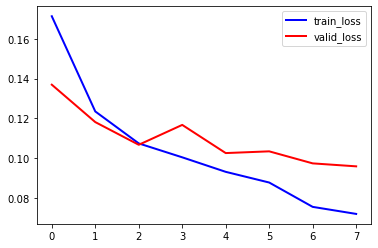

In [61]:
#Plot the loss at each epoch for training and validation set.
plt.plot( history.index, 'train_loss', data=history, marker='', color='blue', linewidth=2,label='train_loss')
plt.plot( history.index, 'valid_loss', data=history, marker='', color='red', linewidth=2,label='valid_loss')
plt.legend()


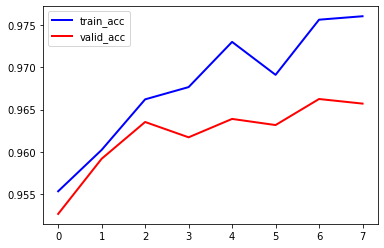

In [63]:
#Plot the accuracy at each epoch for training and validation set.
plt.plot( history.index, 'train_acc', data=history, marker='', color='blue', linewidth=2,label='train_acc')
plt.plot( history.index, 'valid_acc', data=history, marker='', color='red', linewidth=2,label='valid_acc')
plt.legend()

# Make Predictions

In [66]:
# Load the model
model=models.resnet34(pretrained=True)
model.fc = nn.Linear(512, num_classes)

model.load_state_dict(torch.load('model.pt'))
model.cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
# Testing the model

def test(model,test_loader):
    model.eval()
    n_samples=0
    n_correct=0
    predict=[]
    actual=[]
    with torch.no_grad():
        for images,labels in test_loader:
            images=images.cuda()
            labels=labels.cuda()
            actual.append(labels.tolist())
        
            #make predictions
            outputs=model(images)
            _,predictions=torch.max(outputs,1)
            n_samples+=labels.shape[0]
            n_correct+=(predictions==labels).sum().item()
        
            predict.append(predictions.tolist())
        
        
        actual=np.array(sum(actual,[]))
        predict=np.array(sum(predict,[]))
        acc=np.round(100*n_correct/n_samples,3)
    
    return acc,actual,predict
    
        
accuracy,actuals,predictions=test(model,test_loader=valid_loader)

print(f'Accuracy: {accuracy}%')        

Accuracy: 96.625%


In [68]:
#confusion matrix
print(classification_report(actuals,predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2801
           1       0.96      0.97      0.97      2710

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



<AxesSubplot:>

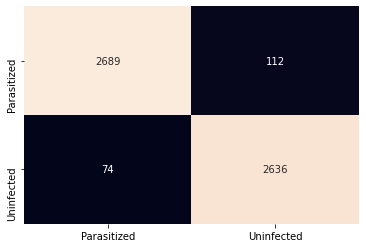

In [69]:
#classification report
results=confusion_matrix(actuals,predictions)
sns.heatmap(results, annot=True, fmt="d",cbar=False,xticklabels=['Parasitized','Uninfected'], yticklabels=['Parasitized','Uninfected'])

        